In [70]:
#Import necessary libraries
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve
import shap

In [2]:
#Load in the data
df = pd.read_csv('data.csv')

In [3]:
#We have some information on what the variables mean, but let's glimpse
df.head()

,patient_id,site_id,D1,D2,D3,D4,Y1,Y2,Y3,Y4,...,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80
0,1,1,1,0,0,0,1,1,0,0,...,4.452960,7.210176,1.394827,3.084498,4.567128,2.323932,3.463742,7.682944,3.980290,6.868684
1,2,2,0,0,0,0,1,0,1,1,...,3.201407,5.302224,0.185738,1.262846,4.201499,0.703098,2.685185,5.236544,2.872772,4.540065
2,3,3,1,1,0,0,0,0,0,0,...,5.173139,7.451871,1.895855,4.251413,7.017735,2.508128,4.976342,8.039998,5.189607,6.382312
3,4,4,1,1,0,1,1,1,0,0,...,6.076691,5.775188,2.430162,2.682373,3.972757,2.173866,1.882294,6.404648,4.377481,5.499923
4,5,5,1,0,0,0,0,1,0,0,...,3.330511,6.727117,3.562529,3.154198,2.470176,-0.753595,2.439319,6.834649,2.283270,4.071917


In [4]:
#Df shape and info
print(df.shape) #10,000 rows and 92 columns
df.info()
#Mostly ints and floats, one boolean value

(10000, 92)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 92 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   patient_id  10000 non-null  int64  
 1   site_id     10000 non-null  int64  
 2   D1          10000 non-null  int64  
 3   D2          10000 non-null  int64  
 4   D3          10000 non-null  int64  
 5   D4          10000 non-null  int64  
 6   Y1          10000 non-null  int64  
 7   Y2          10000 non-null  int64  
 8   Y3          10000 non-null  int64  
 9   Y4          10000 non-null  int64  
 10  Y5          10000 non-null  int64  
 11  W           10000 non-null  bool   
 12  X1          10000 non-null  float64
 13  X2          10000 non-null  float64
 14  X3          10000 non-null  float64
 15  X4          10000 non-null  float64
 16  X5          10000 non-null  float64
 17  X6          10000 non-null  float64
 18  X7          10000 non-null  float64
 19  X8          10

In [5]:
#Looks like "W" column is supposed to be an integer not a boolean
#Let's convert it
print(df['W'].head())
df['W'] = df['W'].astype(int)
print(df['W'].head()) #It worked

0     True
1    False
2    False
3    False
4     True
Name: W, dtype: bool
0    1
1    0
2    0
3    0
4    1
Name: W, dtype: int64


patient_id    0
site_id       0
D1            0
D2            0
D3            0
             ..
X76           0
X77           0
X78           0
X79           0
X80           0
Length: 92, dtype: int64


<Axes: >

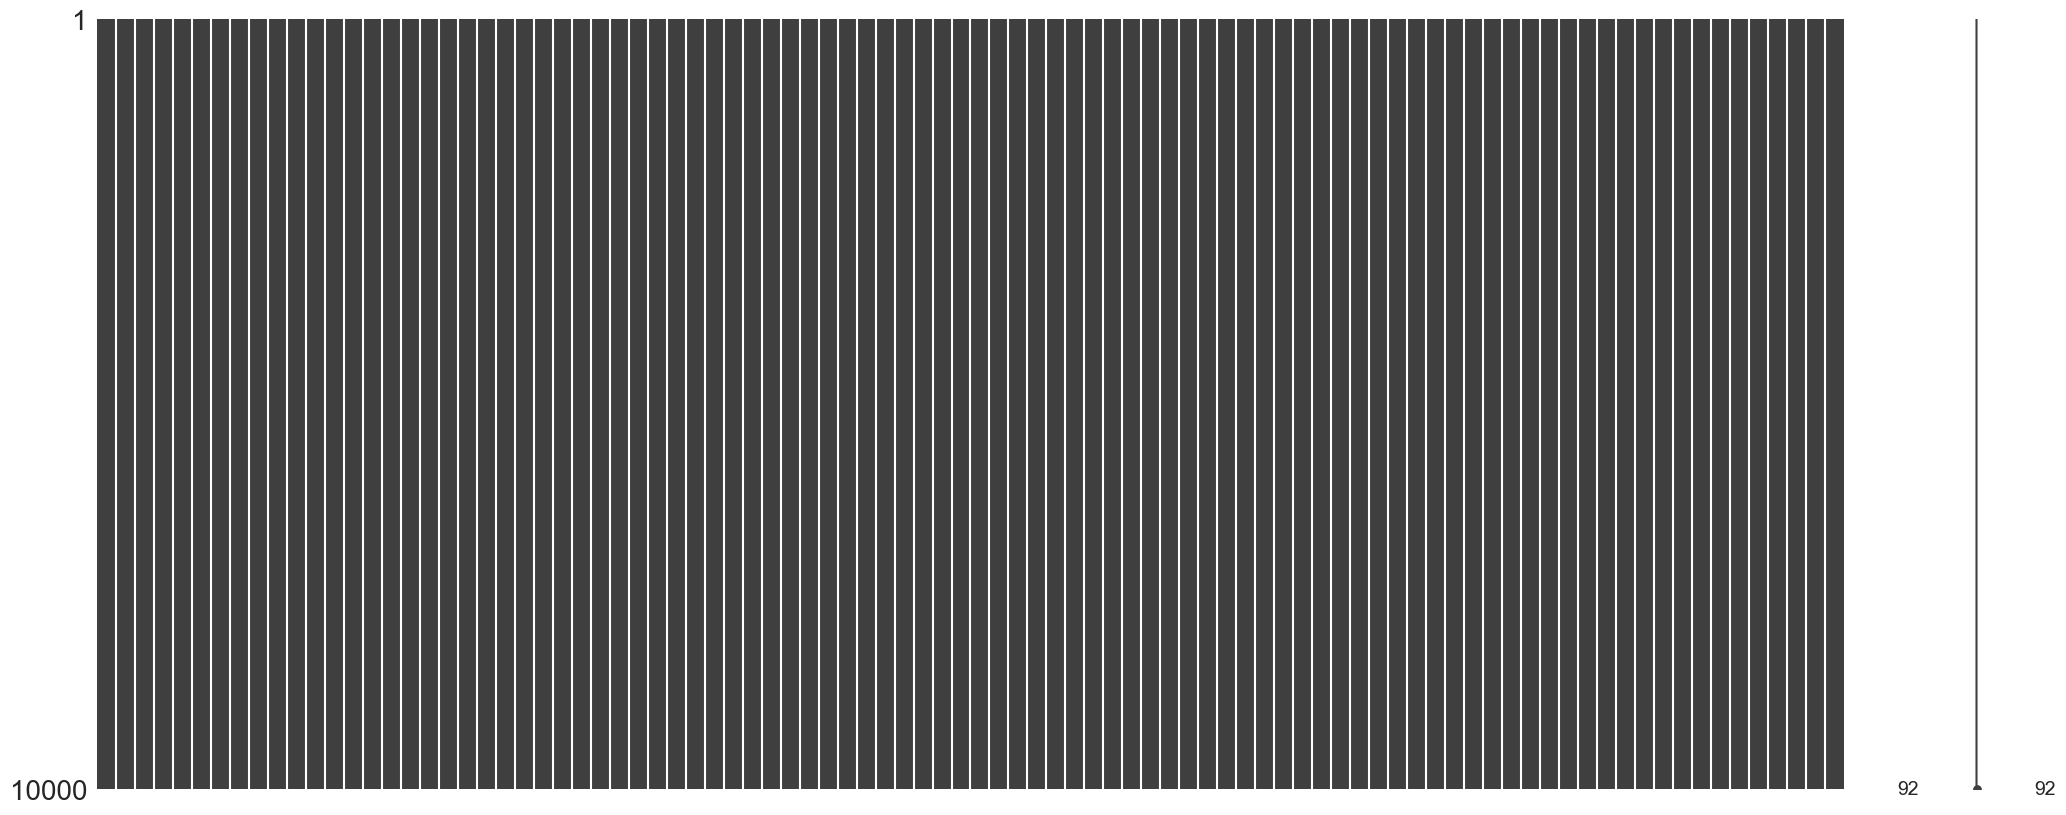

In [6]:
#Data quality checks
print(df.isna().sum())
msno.matrix(df)

In [7]:
#Looking ahead at the prompt, we are asked about condition D1, treatment W, and outcome Y1
#Let's see how many patients have condition D1; fairly balanced but not an even split
condition_d1_counts = df['D1'].value_counts()
condition_d1_counts

D1
1    6020
0    3980
Name: count, dtype: int64

In [8]:
#Looking ahead at the prompt, we are asked about condition D1, treatment W, and outcome Y1
#Let's see how many patients have treatment W; fairly balanced
treatment_W_counts = df['W'].value_counts()
treatment_W_counts

W
1    5336
0    4664
Name: count, dtype: int64

In [9]:
#Looking ahead at the prompt, we are asked about condition D1, treatment W, and outcome Y1
#Let's see how many patients have outcome Y1; fairly balanced
outcome_Y1_counts = df['Y1'].value_counts()
outcome_Y1_counts

Y1
1    5088
0    4912
Name: count, dtype: int64

In [10]:
#Some quick visualizations as part of our EDA, just to be complete
#Let's plot some histograms of some patient characteristics

#Approximately normally distributed
fig = px.histogram(df, x="X20")
fig.show()

In [11]:
#Some quick visualizations as part of our EDA, just to be complete
#Let's plot some histograms of some patient characteristics

#Approximately normally distributed
fig = px.histogram(df, x="X75")
fig.show()

In [12]:
#Let's quickly look at skew and kurtosis and isolate variables that may need transformation

results = []

for col in df.columns:
    if np.dtype(df[col]) == 'float64':
        col_skew = skew(df[col].dropna())
        col_kurt = kurtosis(df[col].dropna())
        results.append({"variable": col, "skew": col_skew, "kurtosis": col_kurt})

dist_df = pd.DataFrame(results)
dist_df.head()

,variable,skew,kurtosis
0,X1,0.033670,0.042838
1,X2,-0.010834,-0.076116
2,X3,0.067399,0.028238
3,X4,-0.015803,0.043253
4,X5,0.001866,-0.051682


In [13]:
#Normal skew is between -1 and 1
#Normal kurtosis is <3
#Let's see if there are any flags

skewed_vars = dist_df[(dist_df['skew'] < -1) | (dist_df['skew'] > 1)]
print(skewed_vars)
kurtosis_vars = dist_df[(dist_df['kurtosis'] > 3)]
print(kurtosis_vars)

#Nice!

Empty DataFrame
Columns: [variable, skew, kurtosis]
Index: []
Empty DataFrame
Columns: [variable, skew, kurtosis]
Index: []


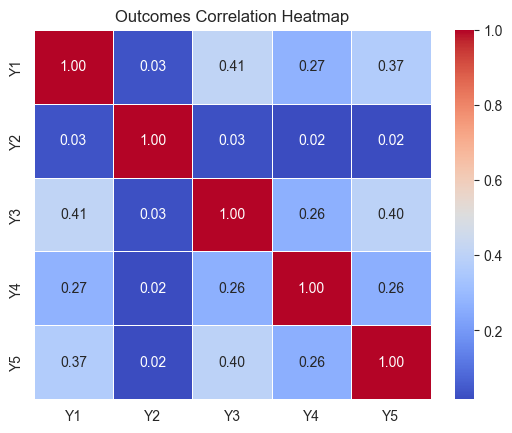

In [14]:
#There are
outcomes_df = df[['Y1', 'Y2', 'Y3', 'Y4', 'Y5']]
outcomes_matrix = outcomes_df.corr()
sns.heatmap(outcomes_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Outcomes Correlation Heatmap")
plt.show()

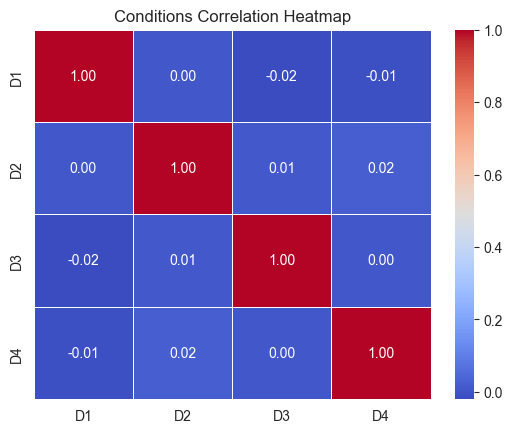

In [15]:
#Let's see if there are correlations among conditions -- doesn't look like it, so we can treat them independently
conditions_df = df[['D1', 'D2', 'D3', 'D4']]
conditions_matrix = conditions_df.corr()
sns.heatmap(conditions_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Conditions Correlation Heatmap")
plt.show()

In [ ]:
#Finally, let's address our prompt
#Which patients with condition D1 would you recommend be given treatment W to reduce their risk of outcome Y1?

#Assumptions
#From corr matrix, let's assume that outcomes can co-occur or be dependent on other outcomes, treatments, etc.; as such we will exclude the other outcomes from analysis to prevent data leak
#Conditions/diagnoses D2-D4 appear independent based on corr heatmap, and will be included as predictors; we will still perform regularization techniques to prevent overfitting and evaluate interaction terms when feasible

#Process
#We are trying to predict outcome Y1; this will be the dependent variable
#We are only interested in patients with condition D1; we will filter the dataset to only include these patients
#Dimension reduction of patient characteristics may be necessary given the large number of variables; we will perform PCA or RF feature importance analysis
#Build baseline logistic regression model
#Build advanced LR model, random forest, and XGBoost models
#Analyze the relationship between treatment W and outcome Y1 among these patients
#Analyze model metrics, with confusion matrices predicting outcome, precision, recall, f1 score, AUC-ROC, etc.
#Analyze model quality, VIF, residuals, etc.

In [35]:
#Data preprocessing/feature extraction/transformation
#We may perform feature extraction with interaction terms
#Preprocessing - will standardize all variables with minmax scaler
#PCA for dimension reduction (can consider RF with feature importance as well)

In [16]:
#Drop the other outcome variables per above reasoning
print(df.shape)
to_exclude = ['Y2', 'Y3', 'Y4', 'Y5']
d1_patients = df.drop(to_exclude, axis=1)
print(d1_patients.shape)

(10000, 92)
(10000, 88)


In [17]:
#Let's filter patients with condition D1 and just make sure we still have treatment and outcome balance
print(d1_patients.shape)
d1_patients = d1_patients[d1_patients['D1'] == 1]
print(d1_patients.shape)
print(d1_patients['W'].value_counts()) #Good balance
print(d1_patients['Y1'].value_counts()) #Good balance

(10000, 88)
(6020, 88)
W
1    3231
0    2789
Name: count, dtype: int64
Y1
1    3088
0    2932
Name: count, dtype: int64


In [18]:
#Let's look at site distribution, we will keep this categorcial
d1_patients['site_id'].value_counts()

site_id
10    631
7     621
9     616
8     612
6     599
4     598
1     594
5     591
3     582
2     576
Name: count, dtype: int64

In [42]:
#Separate features and target, separate train and test sets
X = d1_patients.drop('Y1', axis=1)
y = d1_patients['Y1']

patient_id = X['patient_id'] #Preserve patient id for later use
non_scaled_vars = ['site_id', 'D1', 'D2', 'D3', 'D4', 'W']  #Binary variables and identifier not to be scaled

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [20]:
#Drop the non-scaled variables
X_train_non_scaled = X_train[non_scaled_vars]
X_test_non_scaled = X_test[non_scaled_vars]
X_train_scaled_vars = X_train.drop(non_scaled_vars, axis=1)
X_test_scaled_vars = X_test.drop(non_scaled_vars, axis=1)

Xcol_names = X_train_scaled_vars.columns
ycol_names = y_train.name

In [21]:
#We probably don't need to, but for good practice let's scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_scaled_vars)
X_test_scaled = scaler.transform(X_test_scaled_vars)

In [44]:
#PCA on patient characteristics, because there are many - we will keep the components that explain 80% of variance as rule of thumb
pca_X_train = pd.DataFrame(X_train_scaled, columns=Xcol_names)

#We'll just run with default parameters for now
pca_model = PCA(random_state=42,
                n_components=20) #Choosing 20 components arbitrarily for now, alternatively we could set n_components to a float between 0 and 1 to specify variance threshold (0.8)
X_train_pca = pca_model.fit_transform(pca_X_train)

In [46]:
#Let's see how much variance we can explain with 20 components
cumsum = np.cumsum(pca_model.explained_variance_ratio_)
print(cumsum) #Nearly 80%, I'll take it!

[0.21077638 0.25697635 0.30108056 0.34092819 0.38042371 0.41722908
 0.4522831  0.4869479  0.52099958 0.55186188 0.58244472 0.61178493
 0.6386945  0.66532061 0.68954644 0.71309045 0.73594948 0.75792843
 0.77772373 0.79644131]


In [47]:
#If we ran a bunch of components, we can visualize cumulative explained variance and the "elbow"
#We'll just run with default parameters for now
pca_viz = PCA(random_state=42,
              n_components=0.9999)
pca_viz.fit_transform(pca_X_train)
cumsum_viz = np.cumsum(pca_viz.explained_variance_ratio_)

fig = px.line(x=range(1, 46), y=cumsum_viz, labels={'x': 'Number of Components', 'y': 'Cumulative Explained Variance'})
fig.update_layout(title='PCA Cumulative Explained Variance')
fig.show()

#Not much of an elbow here, should be around n_components=20

In [65]:
#We're done with PCA
#Let's add back in the variables that we dropped
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])], index=X_train_non_scaled.index) #Make sure indices align
X_train_clean = pd.concat([X_train_pca_df, X_train_non_scaled], axis=1)

In [66]:
#Sanity check
X_train_clean.head(25)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC17,PC18,PC19,PC20,site_id,D1,D2,D3,D4,W
4786,-0.737701,0.110965,0.224144,-0.398054,0.069203,0.299339,-0.097694,-0.096290,-0.022547,-0.307671,...,-0.056827,-0.146159,-0.135441,-0.252709,7,1,0,0,0,0
5528,0.012383,0.029718,0.118850,0.287696,-0.250627,-0.207689,-0.074713,0.260431,-0.215975,0.172260,...,0.259244,-0.115633,-0.007428,0.007823,9,1,0,0,0,0
5867,-0.345871,0.027758,0.349148,-0.017408,0.224791,0.155633,-0.016571,0.114481,-0.136745,-0.214092,...,-0.064831,-0.450319,-0.147788,-0.083334,8,1,0,1,0,0
7598,0.419139,-0.083838,0.239526,-0.001852,-0.321250,0.122636,-0.083037,0.203968,-0.060946,-0.017000,...,0.136120,0.077663,-0.341960,-0.084642,9,1,0,0,0,1
7175,-0.403600,0.296095,-0.240300,0.132517,-0.185292,-0.263271,-0.236825,-0.188779,-0.064373,0.270196,...,0.176575,0.142717,-0.136009,-0.213692,6,1,1,1,0,0
7586,0.084037,-0.476706,0.319532,0.429931,0.505965,-0.365294,-0.317782,0.017714,-0.148117,0.522806,...,-0.180066,-0.082591,-0.140498,-0.075736,7,1,0,0,1,0
4012,0.364573,0.361006,0.084291,0.184466,-0.519430,-0.146769,0.122512,-0.358856,0.057819,-0.376200,...,0.276666,-0.028564,-0.044335,-0.154228,3,1,1,0,1,0
3333,0.155358,-0.090600,-0.061499,-0.256159,-0.218211,0.240216,0.042457,-0.164086,0.413966,0.178386,...,0.076745,-0.386085,0.059061,0.051865,4,1,1,1,1,1
6543,-0.595331,-0.068934,0.106360,-0.375782,0.067944,-0.108332,0.209698,-0.656181,0.101617,0.099833,...,0.212579,0.127893,0.220378,-0.062208,4,1,0,0,1,0
7567,-0.372129,-0.023994,-0.200585,-0.029735,-0.259717,0.001097,-0.227187,-0.028941,0.103429,-0.011876,...,-0.148046,-0.171999,0.066583,-0.054847,8,1,1,0,1,0


<Axes: >

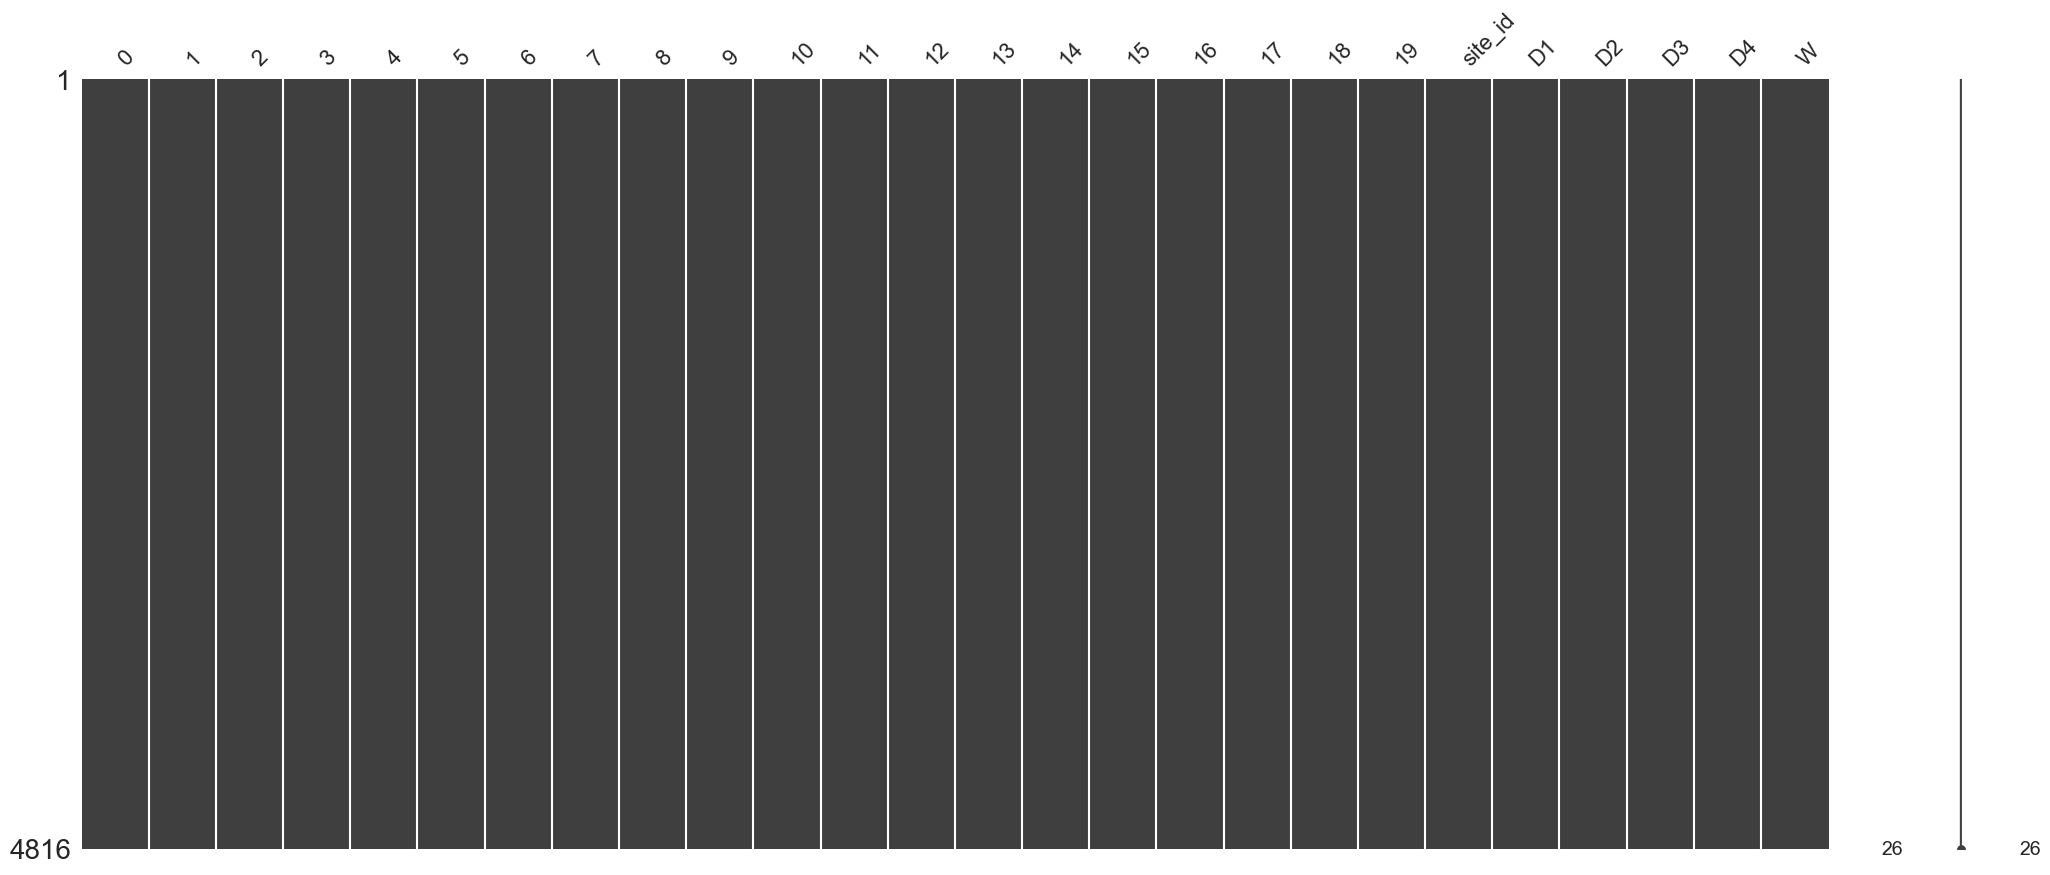

In [60]:
msno.matrix(X_train_clean)

In [80]:
#We need to add interaction terms between treatment W and the principal components
for pc in X_train_pca_df.columns:
    interaction_term = X_train_clean['W'] * X_train_clean[pc]
    X_train_clean[f'{pc}_W_interaction'] = interaction_term

In [81]:
X_train_clean.head(25)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC11_W_interaction,PC12_W_interaction,PC13_W_interaction,PC14_W_interaction,PC15_W_interaction,PC16_W_interaction,PC17_W_interaction,PC18_W_interaction,PC19_W_interaction,PC20_W_interaction
4786,-0.737701,0.110965,0.224144,-0.398054,0.069203,0.299339,-0.097694,-0.096290,-0.022547,-0.307671,...,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000
5528,0.012383,0.029718,0.118850,0.287696,-0.250627,-0.207689,-0.074713,0.260431,-0.215975,0.172260,...,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000
5867,-0.345871,0.027758,0.349148,-0.017408,0.224791,0.155633,-0.016571,0.114481,-0.136745,-0.214092,...,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
7598,0.419139,-0.083838,0.239526,-0.001852,-0.321250,0.122636,-0.083037,0.203968,-0.060946,-0.017000,...,0.002339,-0.282489,0.170444,-0.177611,0.104471,-0.168076,0.136120,0.077663,-0.341960,-0.084642
7175,-0.403600,0.296095,-0.240300,0.132517,-0.185292,-0.263271,-0.236825,-0.188779,-0.064373,0.270196,...,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000
7586,0.084037,-0.476706,0.319532,0.429931,0.505965,-0.365294,-0.317782,0.017714,-0.148117,0.522806,...,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
4012,0.364573,0.361006,0.084291,0.184466,-0.519430,-0.146769,0.122512,-0.358856,0.057819,-0.376200,...,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000
3333,0.155358,-0.090600,-0.061499,-0.256159,-0.218211,0.240216,0.042457,-0.164086,0.413966,0.178386,...,0.222013,-0.203377,-0.011232,-0.008195,0.209088,0.253028,0.076745,-0.386085,0.059061,0.051865
6543,-0.595331,-0.068934,0.106360,-0.375782,0.067944,-0.108332,0.209698,-0.656181,0.101617,0.099833,...,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
7567,-0.372129,-0.023994,-0.200585,-0.029735,-0.259717,0.001097,-0.227187,-0.028941,0.103429,-0.011876,...,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000


In [67]:
#Now let's apply these transformations to the test set
pca_X_test = pd.DataFrame(X_test_scaled, columns=Xcol_names)
X_test_pca = pca_model.transform(pca_X_test)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])], index=X_test_non_scaled.index) #Make sure indices align
X_test_clean = pd.concat([X_test_pca_df, X_test_non_scaled], axis=1)

In [82]:
#We need to add interaction terms between treatment W and the principal components
for pc in X_test_pca_df.columns:
    interaction_term = X_test_clean['W'] * X_test_clean[pc]
    X_test_clean[f'{pc}_W_interaction'] = interaction_term

In [83]:
#Sanity check
X_test_clean.head(25)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC11_W_interaction,PC12_W_interaction,PC13_W_interaction,PC14_W_interaction,PC15_W_interaction,PC16_W_interaction,PC17_W_interaction,PC18_W_interaction,PC19_W_interaction,PC20_W_interaction
7866,-0.054109,-0.374521,-0.311283,-0.126582,0.056987,-0.255533,-0.302453,-0.213313,0.112877,0.130358,...,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000
5237,0.389720,-0.228318,0.065661,-0.281441,-0.016241,-0.408521,0.189554,0.139846,-0.257424,-0.022606,...,0.249162,-0.249277,0.315622,0.052458,-0.249564,-0.048550,-0.087455,-0.011426,-0.218765,0.188131
8379,0.176644,0.372884,0.193805,0.280997,0.199896,0.288722,0.014084,0.093057,-0.039705,0.215853,...,0.140888,0.108599,-0.202527,0.078725,-0.131254,0.053020,-0.138136,-0.085111,-0.033461,-0.078217
2640,-0.891570,0.039018,0.064486,0.596145,-0.251455,-0.164916,-0.335884,-0.018446,0.165618,0.029047,...,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000
5576,-0.333947,0.598232,0.244354,0.191659,-0.294053,0.219859,-0.188190,0.135298,-0.193598,-0.182808,...,0.069883,0.175598,-0.068169,-0.141337,-0.026928,0.098802,0.282768,-0.019922,0.170039,-0.261079
3987,-0.151308,0.471923,0.072499,0.022412,-0.020594,0.417220,0.116680,0.201969,0.213268,0.019363,...,-0.098133,-0.097373,0.266942,-0.252054,-0.049060,0.171953,0.124790,0.035868,-0.273235,0.037173
1306,1.057160,-0.295800,-0.111310,0.347793,-0.281491,0.188747,-0.182282,-0.163112,0.167979,-0.037989,...,0.159401,0.037221,-0.226201,-0.096123,0.070791,-0.236752,0.073101,0.081478,0.186412,0.022410
4375,0.029940,0.661378,0.187447,0.072537,0.058515,0.207402,0.020185,0.033899,0.085484,0.279199,...,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000
7750,0.490099,-0.057061,-0.431032,-0.260242,0.117225,0.436967,-0.145857,-0.103502,-0.090747,0.048576,...,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000
4594,1.369966,0.129228,-0.335646,-0.077351,-0.057493,0.148258,-0.286987,-0.008069,-0.122495,-0.217986,...,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000


In [84]:
#Baseline logistic regression model
#No hyperparameter tuning for baseline model

baseline_model = LogisticRegression(max_iter=1000,
                                    random_state=42)

baseline_model.fit(X_train_clean, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [85]:
#Get metrics for baseline model

y_pred_baseline = baseline_model.predict(X_test_clean)
y_proba_baseline = baseline_model.predict_proba(X_test_clean)[:, 1]
print("Baseline Logistic Regression Model Metrics:")
print(classification_report(y_test, y_pred_baseline))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_baseline))
roc_auc_baseline = roc_auc_score(y_test, y_proba_baseline)
print(f"AUC-ROC: {roc_auc_baseline:.4f}")
precision_score_baseline = precision_score(y_test, y_pred_baseline)
recall_score_baseline = recall_score(y_test, y_pred_baseline)
f1_score_baseline = f1_score(y_test, y_pred_baseline)
print(f"Precision: {precision_score_baseline:.4f}")
print(f"Recall: {recall_score_baseline:.4f}")
print(f"F1 Score: {f1_score_baseline:.4f}")

Baseline Logistic Regression Model Metrics:
              precision    recall  f1-score   support

           0       0.70      0.72      0.71       586
           1       0.72      0.71      0.72       618

    accuracy                           0.71      1204
   macro avg       0.71      0.71      0.71      1204
weighted avg       0.71      0.71      0.71      1204

Confusion Matrix:
[[419 167]
 [178 440]]
AUC-ROC: 0.7784
Precision: 0.7249
Recall: 0.7120
F1 Score: 0.7184


In [86]:
#Okay, let's see if we can improve

#We'll test a few different hyperparameters
C = [0.01, 0.1, 1, 10, 100]
penalties = ['l1', 'l2', 'none']
solver = 'saga' # 'saga' supports both l1 and l2 penalties

for c in C:
    for penalty in penalties:
        if penalty == 'none' and c != 1:
            continue  # Skip invalid combinations
        try:
            model = LogisticRegression(C=c, penalty=penalty, solver=solver, max_iter=1000, random_state=42)
            model.fit(X_train_clean, y_train)
            y_pred = model.predict(X_test_clean)
            y_proba = model.predict_proba(X_test_clean)[:, 1]
            roc_auc = roc_auc_score(y_test, y_proba)
            print(f"Logistic Regression Model with C={c}, penalty={penalty} AUC-ROC: {roc_auc:.4f}")
        except Exception as e:
            print(f"Error with C={c}, penalty={penalty}: {e}")

Logistic Regression Model with C=0.01, penalty=l1 AUC-ROC: 0.6997
Logistic Regression Model with C=0.01, penalty=l2 AUC-ROC: 0.7611
Logistic Regression Model with C=0.1, penalty=l1 AUC-ROC: 0.7723
Logistic Regression Model with C=0.1, penalty=l2 AUC-ROC: 0.7761
Logistic Regression Model with C=1, penalty=l1 AUC-ROC: 0.7787
Logistic Regression Model with C=1, penalty=l2 AUC-ROC: 0.7782
Error with C=1, penalty=none: The 'penalty' parameter of LogisticRegression must be a str among {'l2', 'elasticnet', 'l1'} or None. Got 'none' instead.
Logistic Regression Model with C=10, penalty=l1 AUC-ROC: 0.7786
Logistic Regression Model with C=10, penalty=l2 AUC-ROC: 0.7786
Logistic Regression Model with C=100, penalty=l1 AUC-ROC: 0.7786
Logistic Regression Model with C=100, penalty=l2 AUC-ROC: 0.7786


In [87]:
#The best aur-roc (assuming this is our key metric) was C=10 and C=100 with l1 or l2 penalty
#I'd pick the model that computes fastest among these: C=10 and l2 penalty

best_log_model = LogisticRegression(C=10, penalty='l2', solver=solver, max_iter=1000, random_state=42)
best_log_model.fit(X_train_clean, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,10
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'saga'
,max_iter,1000
,multi_class,'deprecated'


In [89]:
#Metrics for best logistic regression model
y_pred_baseline = best_log_model.predict(X_test_clean)
y_proba_baseline = best_log_model.predict_proba(X_test_clean)[:, 1]

print("Baseline Logistic Regression Model Metrics:")
print(classification_report(y_test, y_pred_baseline))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_baseline))
roc_auc_baseline = roc_auc_score(y_test, y_proba_baseline)
print(f"AUC-ROC: {roc_auc_baseline:.4f}")
precision_score_baseline = precision_score(y_test, y_pred_baseline)
recall_score_baseline = recall_score(y_test, y_pred_baseline)
f1_score_baseline = f1_score(y_test, y_pred_baseline)
print(f"Precision: {precision_score_baseline:.4f}")
print(f"Recall: {recall_score_baseline:.4f}")
print(f"F1 Score: {f1_score_baseline:.4f}")

Baseline Logistic Regression Model Metrics:
              precision    recall  f1-score   support

           0       0.70      0.72      0.71       586
           1       0.73      0.71      0.72       618

    accuracy                           0.71      1204
   macro avg       0.71      0.71      0.71      1204
weighted avg       0.71      0.71      0.71      1204

Confusion Matrix:
[[421 165]
 [179 439]]
AUC-ROC: 0.7786
Precision: 0.7268
Recall: 0.7104
F1 Score: 0.7185


In [90]:
#Precision: TP/(TP+FP) - Of all patients predicted to have outcome Y1, how many actually did
##Precision is 70%, so we have about a 30% false positive rate

#Recall: TP/(TP+FN) - Of all patients who actually had outcome Y1, how many were correctly predicted
##Recall is 70%, so we are missing about 30% of patients who will have outcome Y1

#F1 Score: Harmonic mean of precision and recall

#AUC-ROC: Area under the ROC curve, measures model's ability to distinguish between classes

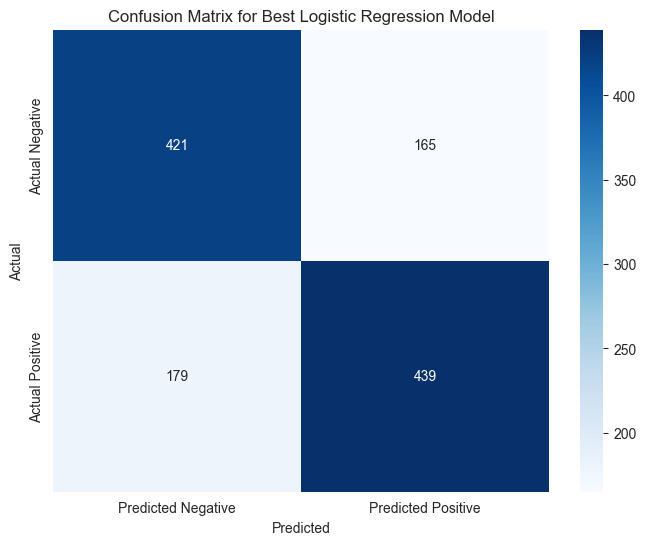

In [91]:
#Seaborn confusion matrix plot
conf_matrix = confusion_matrix(y_test, y_pred_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix for Best Logistic Regression Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

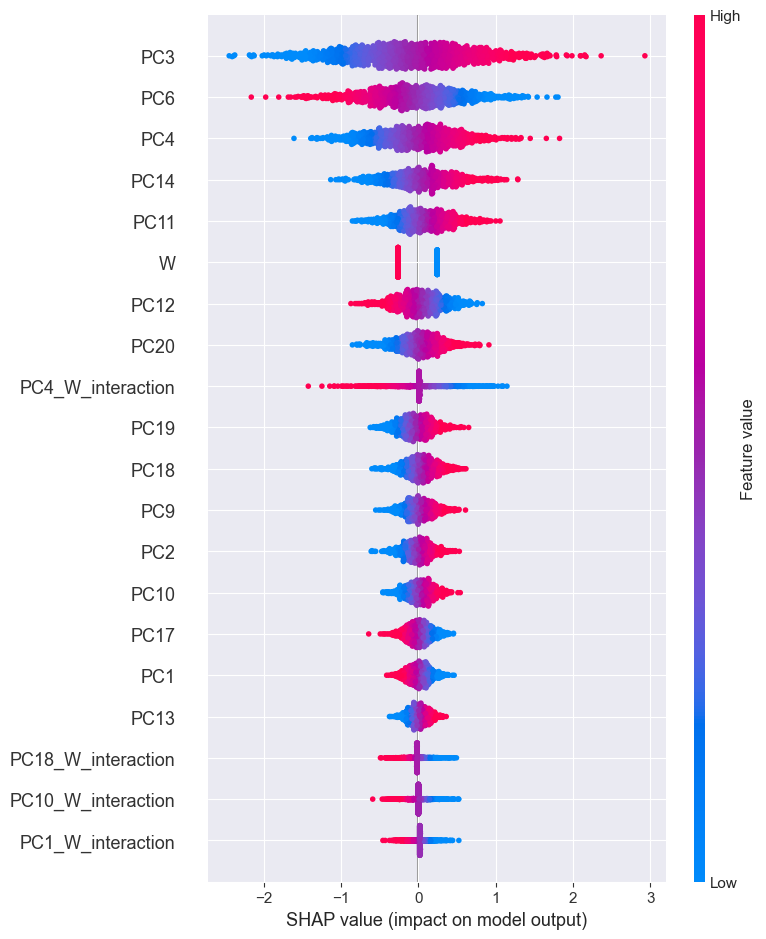

In [92]:
#Let's do SHAP for explainability of our best model
explainer = shap.Explainer(best_log_model, X_train_clean)
shap_values = explainer(X_test_clean)
shap.summary_plot(shap_values, X_test_clean)

#PC3, PC6, PC4, PC14, PC11, W, seem to be the most important features

In [93]:
#Let's go back to the question
#Which patients with condition D1 would you recommend be given treatment W to reduce their risk of outcome Y1?
X_treated = X_test_clean.copy()
X_control = X_test_clean.copy()

#Turn treatment on and off
X_treated['W'] = 1 #Everyone gets treatment
X_control['W'] = 0 #No one gets treatment

In [94]:
#Need to recalculate interaction terms because W changed
for pc in [c for c in X_treated.columns if c.startswith('PC') and '_W_interaction' not in c]:
    X_treated[f'{pc}_W_interaction'] = X_treated[pc] * X_treated['W']
    X_control[f'{pc}_W_interaction'] = X_control[pc] * X_control['W']


In [95]:
#Predict risk of outcome Y1 under both scenarios (both timelines)
p_treated = best_log_model.predict_proba(X_treated)[:, 1]
p_control = best_log_model.predict_proba(X_control)[:, 1]

In [96]:
#Risk reduction of treatment
rr = p_control - p_treated

In [97]:
#Make a dataframe with the risk with and without treatment
results = pd.DataFrame({
    'patient_id': X_test_clean.index,
    'risk_no_treatment': p_control,
    'risk_with_treatment': p_treated,
    'estimated_benefit': rr
})

In [99]:
results.head(25)

,patient_id,risk_no_treatment,risk_with_treatment,estimated_benefit
0,7866,0.380309,0.396524,-0.016215
1,5237,0.812750,0.797676,0.015073
2,8379,0.731623,0.471166,0.260456
3,2640,0.934323,0.718325,0.215999
4,5576,0.552209,0.434331,0.117878
5,3987,0.350942,0.161070,0.189872
6,1306,0.519529,0.216559,0.302970
7,4375,0.786551,0.490751,0.295800
8,7750,0.022990,0.037858,-0.014867
9,4594,0.073003,0.054624,0.018379


In [100]:
#What's our benefit cut off?
#We can say any estimated benefit >0.05 (5% absolute risk reduction) is worth treating
treatment_recommendations = results[results['estimated_benefit'] > 0.05]
print(f"Number of patients recommended for treatment W to reduce risk of outcome Y1: {treatment_recommendations.shape[0]}")
treatment_recommendations.head(25)

#Note that this is our test dataset only

Number of patients recommended for treatment W to reduce risk of outcome Y1: 744


,patient_id,risk_no_treatment,risk_with_treatment,estimated_benefit
2,8379,0.731623,0.471166,0.260456
3,2640,0.934323,0.718325,0.215999
4,5576,0.552209,0.434331,0.117878
5,3987,0.350942,0.161070,0.189872
6,1306,0.519529,0.216559,0.302970
7,4375,0.786551,0.490751,0.295800
10,2471,0.703490,0.619481,0.084010
11,1364,0.721375,0.285591,0.435785
12,9876,0.390986,0.195266,0.195720
14,9615,0.786344,0.718146,0.068198


In [101]:
#How many people
print(f"We recommend treatment in {treatment_recommendations.shape[0]} out of {results.shape[0]} patients with condition D1 ({(treatment_recommendations.shape[0]/results.shape[0])*100:.2f}%) to reduce their risk of outcome Y1.")

We recommend treatment in 744 out of 1204 patients with condition D1 (61.79%) to reduce their risk of outcome Y1.


In [ ]:
#Further investigations
#Calibration curves for probability estimates
#VIF for multicollinearity
#I'd like to try RF
#Additional hyperparameter tuning (I like MLFLow)
#Feature engineering